QTM 350 Final Project Analysis Script

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf


df = pd.read_csv("/Users/jackyan/QTM350_final_project/datasets/wdi_data.csv")

df

,Country Name,Country Code,Series Name,Series Code,1970 [YR1970],1971 [YR1971],1972 [YR1972],1973 [YR1973],1974 [YR1974],1975 [YR1975],...,2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023],2024 [YR2024]
0,Afghanistan,AFG,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,37.46,37.932,38.423,38.951,39.469,39.994,...,62.27,62.646,62.406,62.443,62.941,61.454,60.417,65.617,66.035,..
1,Afghanistan,AFG,"Fertility rate, total (births per woman)",SP.DYN.TFRT.IN,7.4,7.432,7.453,7.487,7.526,7.542,...,5.652,5.542,5.433,5.327,5.238,5.145,5.039,4.932,4.84,..
2,Afghanistan,AFG,Population growth (annual %),SP.POP.GROW,2.4452057451213,2.42851631309344,2.44258389899974,2.53475893911385,2.5268442145866,2.41525048462279,...,3.11995924146907,2.53571991833963,2.80833730805469,2.91080959861384,2.98438913621969,3.15360920291972,2.35609779179185,1.43570437048699,2.13559384981397,..
3,Afghanistan,AFG,"School enrollment, primary (% gross)",SE.PRM.ENRR,33.4200096130371,34.3313407897949,34.7526817321777,35.2143707275391,35.7608299255371,36.7159118652344,...,106.182418823242,106.150283813477,106.129997253418,107.780532836914,110.007507324219,..,..,..,..,..
4,Albania,ALB,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,65.234,65.896,66.526,67.107,67.633,68.12,...,78.358,78.643,78.9,79.238,79.467,77.824,76.844,78.769,79.602,..
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1067,Data from database: World Development Indicators,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


1. Dataset cleaning

In [ ]:
# Drop metadata rows
df = df[df["Country Name"].notna()]

# Step 1: Unpivot (melt) all year columns into long format
year_cols = [col for col in df.columns if "YR" in col]
df_long = df.melt(
    id_vars=["Country Name", "Country Code", "Series Name", "Series Code"],
    value_vars=year_cols,
    var_name="Year", value_name="Value"
)

# Step 2: Extract numeric year from column names like "1970 [YR1970]"
df_long["Year"] = df_long["Year"].str.extract(r"(\d{4})").astype(int)

# Step 3: Drop missing or placeholder values (e.g., '..')
df_long = df_long[df_long["Value"].notna()]
df_long = df_long[df_long["Value"] != ".."]

# Step 4: Pivot Series Name into columns
df_wide = df_long.pivot(
    index=["Country Name", "Country Code", "Year"],
    columns="Series Name",
    values="Value"
).reset_index()

# Step 5: Rename indicator columns
df_wide = df_wide.rename(columns={
    "Life expectancy at birth, total (years)": "LifeExpectancy",
    "Fertility rate, total (births per woman)": "FertilityRate",
    "Population growth (annual %)": "PopGrowth",
    "School enrollment, primary (% gross)": "PrimaryEnrollGross"
})

# Step 6: Convert key columns to numeric
for col in ["LifeExpectancy", "FertilityRate", "PopGrowth", "PrimaryEnrollGross"]:
    df_wide[col] = pd.to_numeric(df_wide[col], errors="coerce")

# Step 7: Drop rows where all key indicators are missing
df_clean = df_wide.dropna(
    subset=["LifeExpectancy", "FertilityRate", "PopGrowth", "PrimaryEnrollGross"],
    how="all"
)

# Preview cleaned result
df_clean.head()


Series Name,Country Name,Country Code,Year,FertilityRate,LifeExpectancy,PopGrowth,PrimaryEnrollGross
0,Afghanistan,AFG,1970,7.400,37.460,2.445206,33.420010
1,Afghanistan,AFG,1971,7.432,37.932,2.428516,34.331341
2,Afghanistan,AFG,1972,7.453,38.423,2.442584,34.752682
3,Afghanistan,AFG,1973,7.487,38.951,2.534759,35.214371
4,Afghanistan,AFG,1974,7.526,39.469,2.526844,35.760830


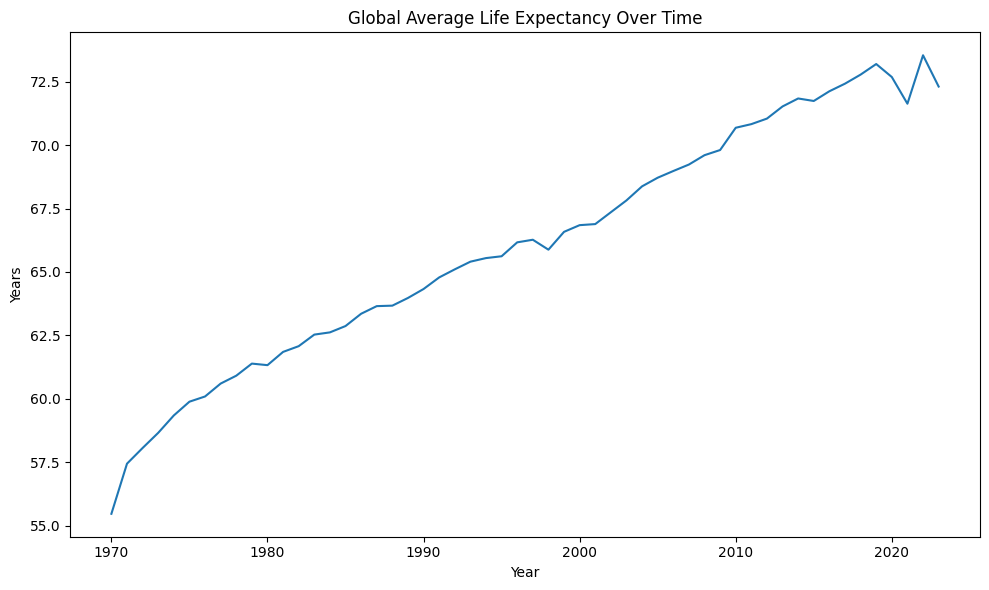

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Make sure columns are numeric
for col in ['LifeExpectancy', 'FertilityRate', 'PopGrowth', 'PrimaryEnrollGross']:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Drop rows with any missing indicator values
df = df_clean.dropna(subset=['LifeExpectancy', 'FertilityRate', 'PopGrowth', 'PrimaryEnrollGross'])

# --------------------------
# 1. Global Trend: Life Expectancy Over Time
# --------------------------
trend = df.groupby('Year')[['LifeExpectancy']].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=trend, x='Year', y='LifeExpectancy')
plt.title("Global Average Life Expectancy Over Time")
plt.ylabel("Years")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

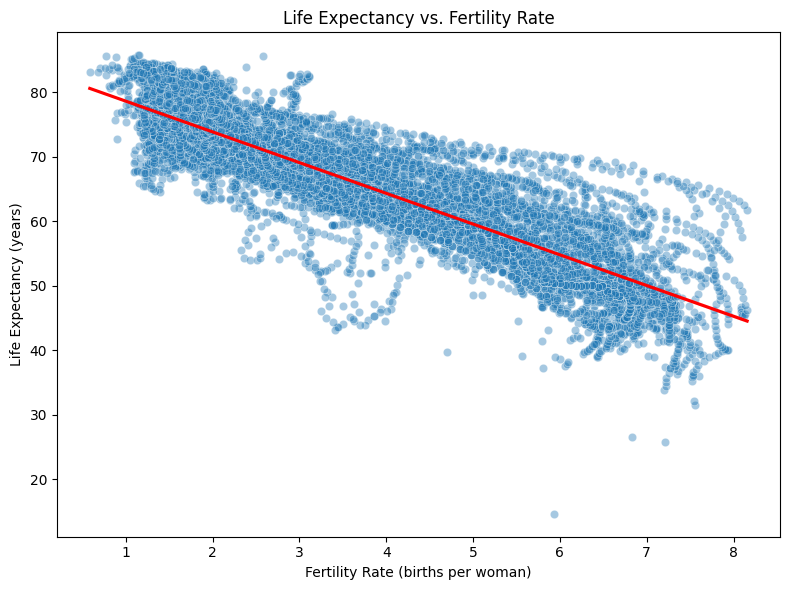

In [16]:
# --------------------------
# 2. Scatterplot: Life Expectancy vs Fertility Rate
# --------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='FertilityRate', y='LifeExpectancy', alpha=0.4)
sns.regplot(data=df, x='FertilityRate', y='LifeExpectancy', scatter=False, color='red')
plt.title("Life Expectancy vs. Fertility Rate")
plt.xlabel("Fertility Rate (births per woman)")
plt.ylabel("Life Expectancy (years)")
plt.tight_layout()
plt.show()

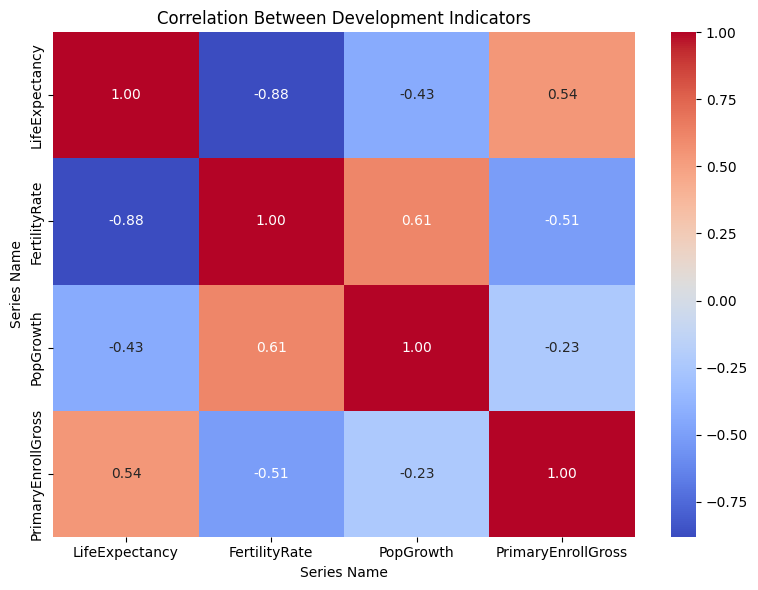

In [17]:
# --------------------------
# 3. Correlation Heatmap
# --------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(df[['LifeExpectancy', 'FertilityRate', 'PopGrowth', 'PrimaryEnrollGross']].corr(),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Development Indicators")
plt.tight_layout()
plt.show()


In [18]:
# --------------------------
# 4. Regression: Life Expectancy ~ Fertility + PopGrowth + School Enroll
# --------------------------
model = smf.ols("LifeExpectancy ~ FertilityRate + PopGrowth + PrimaryEnrollGross", data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         LifeExpectancy   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                 1.481e+04
Date:                Mon, 21 Apr 2025   Prob (F-statistic):               0.00
Time:                        12:45:50   Log-Likelihood:                -32266.
No. Observations:               11020   AIC:                         6.454e+04
Df Residuals:                   11016   BIC:                         6.457e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             77.3726      0

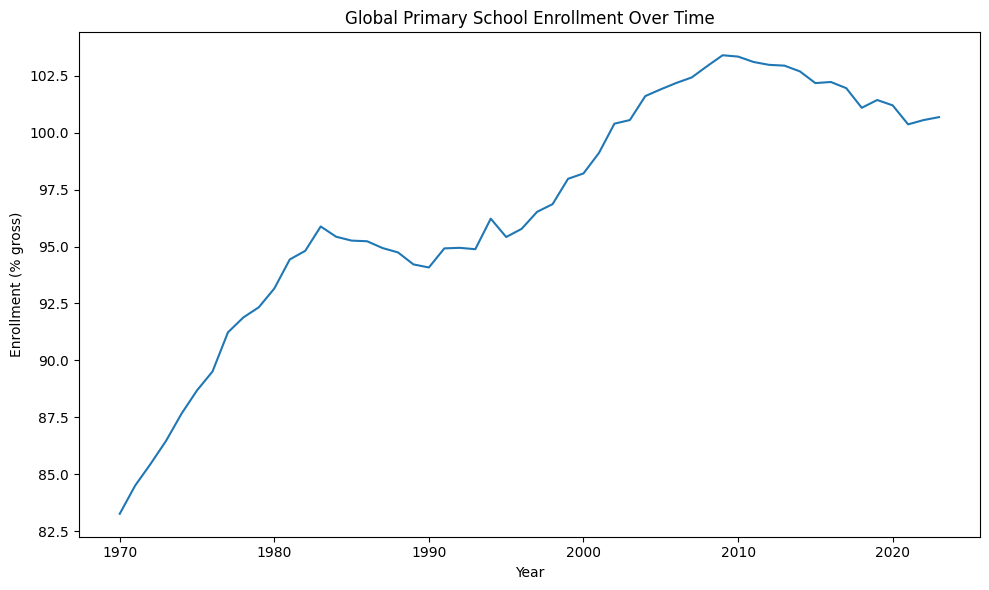

In [19]:
# --------------------------
# 5. School Enrollment Over Time
# --------------------------
enroll_trend = df.groupby('Year')[['PrimaryEnrollGross']].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=enroll_trend, x='Year', y='PrimaryEnrollGross')
plt.title("Global Primary School Enrollment Over Time")
plt.xlabel("Year")
plt.ylabel("Enrollment (% gross)")
plt.tight_layout()
plt.show()